In [3]:
import pandas as pd

# Cargar el DataFrame desde el archivo JSON
df_imported = pd.read_json('new_df.json', orient='records')

# Mostrar los primeros registros para verificar
print(df_imported.head())


                                   subject  \
0                                            
1  treatment options versus migraine types   
2                                            
3                                    cramp   
4                                   Retina   

                                             message                 focus  \
0  literature cardiac amyloidosis please let know...   cardiac amyloidosis   
1  migraine seems spectrum condition rather one e...              migraine   
2             use pyridoxine tablet even im pregnant            pyridoxine   
3               lymphoma cause cramp chemo treatment                 cramp   
4  wonder new research testing macular degenerati...  macular degeneration   

               type                                             answer  
0       information  Cardiac amyloidosis is a disorder caused by de...  
1         treatment  There is no specific cure for migraine headach...  
2  contraindication  Before taking 

In [4]:
!pip install imbalanced-learn


In [52]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Cargar el DataFrame desde el archivo JSON
df = pd.read_json('new_df.json', orient='records')

#columna de etiquetas y las demás son características
X = df.drop('type', axis=1)
y = df['type']

# Identificar las columnas categóricas
columnas_categoricas = X.select_dtypes(include=['object']).columns


# Crear un preprocesador que convierte las características categóricas en numéricas
preprocesador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ],
    remainder='passthrough'  # Dejar las columnas numéricas sin cambios
)

# Crear un pipeline que incluye la imputación de valores faltantes y la codificación de variables categóricas
pipeline = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('imputador', SimpleImputer(strategy='most_frequent'))  # Imputar valores faltantes con la moda
])

# Aplicar el preprocesador a los datos
X_preprocesado = pipeline.fit_transform(X)

# Convertir la matriz dispersa a una matriz densa si es necesario
if hasattr(X_preprocesado, 'toarray'):
    X_preprocesado = X_preprocesado.toarray()

# Calcular el número mínimo de muestras en una clase
minimo_muestras_clase = y.value_counts().min()

# Si hay alguna clase con menos de 2 muestras, duplicar esas muestras manualmente
if minimo_muestras_clase < 2:
    clases_con_una_muestra = y.value_counts()[y.value_counts() < 2].index
    for clase in clases_con_una_muestra:
        X_clase = X_preprocesado[y == clase]
        y_clase = y[y == clase]
        # Duplicar las muestras de esa clase
        X_preprocesado = np.vstack([X_preprocesado, X_clase])
        y = pd.concat([y, y_clase], ignore_index=True)
    # Recalcular el número mínimo de muestras en una clase
    minimo_muestras_clase = y.value_counts().min()

# Ajustar el parámetro k_neighbors de SMOTE para asegurar que sea válido
k_neighbors = min(minimo_muestras_clase - 1, 5)

# Aplicar SMOTE para balancear las clases con k_neighbors ajustado
smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)
X_res, y_res = smote.fit_resample(X_preprocesado, y)

# Obtener los nombres de las características después de la codificación one-hot
nombres_caracteristicas = pipeline.named_steps['preprocesador'].get_feature_names_out()

# Crear un nuevo DataFrame con los datos balanceados
nuevo_df_res = pd.DataFrame(X_res, columns=nombres_caracteristicas)
nuevo_df_res['type'] = y_res

# Verificar el tamaño del DataFrame antes de guardarlo
print(f"El tamaño del DataFrame es: {nuevo_df_res.shape}")

# Guardar el DataFrame balanceado en un archivo CSV en lugar de JSON
nuevo_df_res.to_csv('new_df_res.csv', index=False)

print("\nNuevo DataFrame guardado como 'new_df_res.csv'.")


El tamaño del DataFrame es: (835800, 701)

Nuevo DataFrame guardado como 'new_df_res.csv'.


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Leer el archivo CSV
df_res_sin_nan = pd.read_csv('new_df_res.csv')

# Verificar si hay valores NaN en el DataFrame original
print("Valores NaN en el DataFrame original:")
print(df_res_sin_nan.isnull().sum())

# Eliminar filas con valores NaN en la columna 'type' si los hay
df_res_sin_nan = df_res_sin_nan.dropna(subset=['type'])

# Separar las características y la etiqueta
X = df_res_sin_nan.drop('type', axis=1)
y = df_res_sin_nan['type']

# Imputar los valores NaN en X con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Verificar si hay valores NaN en los datos imputados
print("Valores NaN en los datos imputados:")
print(np.isnan(X_imputed).any())

# Dividir los datos imputados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar un modelo de clasificación (Random Forest en este caso)
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo
precision = accuracy_score(y_test, y_pred)
reporte_clasificacion = classification_report(y_test, y_pred)

print(f"Precisión del modelo: {precision}")
print("Reporte de clasificación:")
print(reporte_clasificacion)


C:\Users\danny\AppData\Local\Temp\ipykernel_11904\1775082238.py:9: DtypeWarning: Columns (700) have mixed types. Specify dtype option on import or set low_memory=False.
  df_res_sin_nan = pd.read_csv('new_df_res.csv')


Valores NaN en el DataFrame original:
cat__subject_                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [3]:
import joblib

# Guardar el modelo entrenado y el imputador en un archivo
joblib.dump(modelo, 'modelo_entrenado.pkl')
joblib.dump(imputer, 'imputador.pkl')

print("Modelo y imputador guardados exitosamente.")


Modelo y imputador guardados exitosamente.


Precisión del modelo: 0.9998743718592965

Reporte de clasificación:
                      precision    recall  f1-score   support

         association       1.00      1.00      1.00      7960
               cause       1.00      1.00      1.00      7960
        complication       1.00      1.00      1.00      7960
    contraindication       1.00      1.00      1.00      7960
           diagnosis       1.00      1.00      1.00      7960
              dosage       1.00      1.00      1.00      7960
     genetic changes       1.00      1.00      1.00      7960
          indication       1.00      1.00      1.00      7960
         information       1.00      1.00      1.00      7960
          ingredient       1.00      1.00      1.00      7960
         inheritance       1.00      1.00      1.00      7960
         interaction       1.00      1.00      1.00      7960
          prevention       1.00      1.00      1.00      7960
           prognosis       1.00      1.00      1.00      7960
 

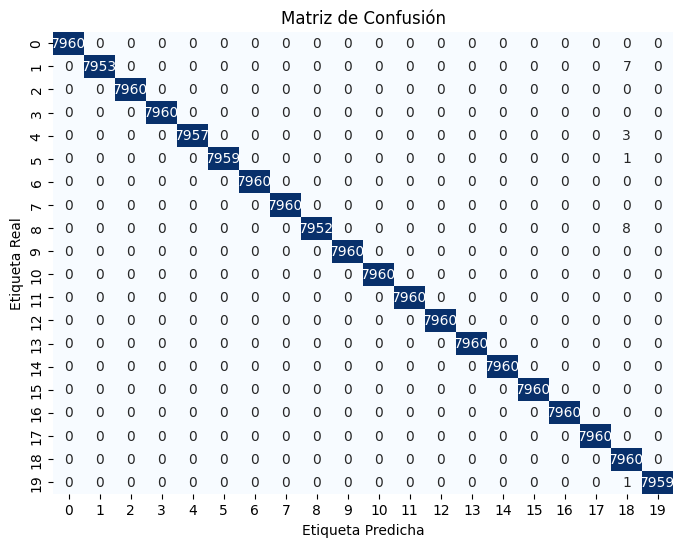

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

# Mostrar un reporte de clasificación detallado
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(conf_matrix)
# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)

# Añadir etiquetas y título
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')

# Mostrar el mapa de calor
plt.show()

In [5]:
import joblib

# Guardar el modelo entrenado y el imputador en un archivo
joblib.dump(modelo, 'modelo_entrenado.pkl')
joblib.dump(imputer, 'imputador.pkl')

print("Modelo y imputador guardados exitosamente.")


Modelo y imputador guardados exitosamente.


In [2]:
import pandas as pd

# Cargar el DataFrame desde el archivo JSON
df = pd.read_json("new_df.json", orient="records")

# Definir una función para buscar respuestas en el DataFrame
def buscar_respuesta(pregunta):
    # Buscar en el DataFrame una fila que contenga la pregunta
    resultado = df[df['message'].str.contains(pregunta, case=False)]
    
    # Si se encuentra una respuesta, devolverla
    if len(resultado) > 0:
        return resultado.iloc[0]['answer']
    else:
        return "Lo siento, no encontré una respuesta para esa pregunta."

# Bucle principal para que el chatbot interactúe con el usuario
while True:
    # Solicitar al usuario que ingrese una pregunta
    pregunta = input("Tú: ")
    
    # Salir del bucle si el usuario ingresa "salir"
    if pregunta.lower() == "salir":
        print("¡Hasta luego!")
        break
    
    # Buscar una respuesta basada en la pregunta del usuario
    respuesta = buscar_respuesta(pregunta)
    
    # Mostrar la respuesta encontrada o un mensaje de error si no se encuentra una respuesta
    print("Chatbot: " + respuesta)


Chatbot: In most cases of diarrhea, the only treatment necessary is replacing lost fluids and electrolytes to prevent dehydration.                  Over-the-counter medicines such as loperamide (Imodium) and bismuth subsalicylate (Pepto-Bismol and Kaopectate) may help stop diarrhea in adults. However, people with bloody diarrhea—a sign of bacterial or parasitic infection—should not use these medicines. If diarrhea is caused by bacteria or parasites, over-the-counter medicines may prolong the problem, so doctors usually prescribe antibiotics instead.                  Medications to treat diarrhea in adults can be dangerous for infants and children and should only be given with a doctor’s guidance.
Chatbot: Cardiac amyloidosis is a disorder caused by deposits of an abnormal protein (amyloid) in the heart tissue. These deposits make it hard for the heart to work properly.
¡Hasta luego!
